# Streaming Input Dataset

We already covered the basics of an iterable dataset ([Python-02-Python](Pytorch-02-Python.ipynb)) and pytorch's `DataLoader` ([Python-05-Pytorch.ipynb](Python-05-Pytorch.ipynb)). In this notebook, we introduce a few datasets that will be used during the hands-on sessions, and practic looping over the dataset using `DataLoader`!


In [1]:
import torch
import numpy as np
SEED=123
np.random.seed(SEED)
torch.manual_seed(SEED)

## MNIST dataset

MNIST is widely used for an introductory machine learning (ML) courses/lectures. Most, if not all, ML libraries provide an easy way (API) to access MNIST and many publicly available dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

### Creating MNIST Dataset
A `torchvision` is a supporting module that has many image-related APIs including an interface (and management) of MNIST dataset. Let's see how we can construct:

In [2]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

Extracting ./mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist-data/MNIST/raw


Extracting ./mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist-data/MNIST/raw


Extracting ./mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist-data/MNIST/raw


Extracting ./mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist-data/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


Here, MNIST is also a type `Dataset` (how? through class inheritance). All torch `Dataset` instance have tow useful and common functions: the length representations and data element access via index.

In [3]:
print( len(dataset)  )
print( type(dataset[0]) )

60000
<class 'tuple'>


That being said, how each data element is presented depends on a particular `Dataset` implementation. In case of MNIST, it is a tuple of length 2: **data** and **label**.

In [4]:
ENTRY=0
data, label = dataset[ENTRY]
print('Type of data  :', type(data),  'shape', data.shape)
print('Type of label :', type(label), 'value', label)

Type of data  : <class 'torch.Tensor'> shape torch.Size([1, 28, 28])
Type of label : <class 'int'> value 5


MNIST is an image of a hand-written digit in 28x28 pixels, gray scale. Note that the data `shape` is `[1,28,28]`. This follows the convention in Pytorch for image data represented as $(Cannel,Height,Width)$, or in short $(C,H,W)$. Let's visualize using `matplotlib.pyplot.imshow`. This function can take $(H,W)$ of a gray scale image. 

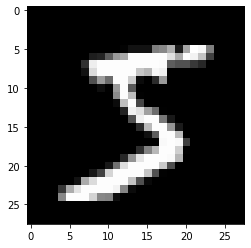

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Draw data
data = data.reshape(data.shape[1:])
plt.imshow(data,cmap='gray')
plt.show()

Let us define a function that can list images and labels in the dataset.

In [6]:
def plot_dataset(dataset,num_image_per_class=10):
    import numpy as np
    num_class = 0
    classes = []
    if hasattr(dataset,'classes'):
        classes=dataset.classes
        num_class=len(classes)
    else: #brute force
        for data,label in dataset:
            if label in classes: continue
            classes.append(label)
        num_class=len(classes)
    
    shape = dataset[0][0].shape
    big_image = np.zeros(shape=[3,shape[1]*num_class,shape[2]*num_image_per_class],dtype=np.float32)
    
    finish_count_per_class=[0]*num_class
    for data,label in dataset:
        if finish_count_per_class[label] >= num_image_per_class: continue
        img_ctr = finish_count_per_class[label]
        big_image[:,shape[1]*label:shape[1]*(label+1),shape[2]*img_ctr:shape[2]*(img_ctr+1)]=data
        finish_count_per_class[label] += 1
        if np.sum(finish_count_per_class) == num_class*num_image_per_class: break
    import matplotlib.pyplot as plt
    fig,ax=plt.subplots(figsize=(8,8),facecolor='w')
    ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
    plt.imshow(np.transpose(big_image,(1,2,0)))
    for c in range(len(classes)):
        plt.text(big_image.shape[1]+shape[1]*0.5,shape[2]*(c+0.6),str(classes[c]),fontsize=16)
    plt.show()

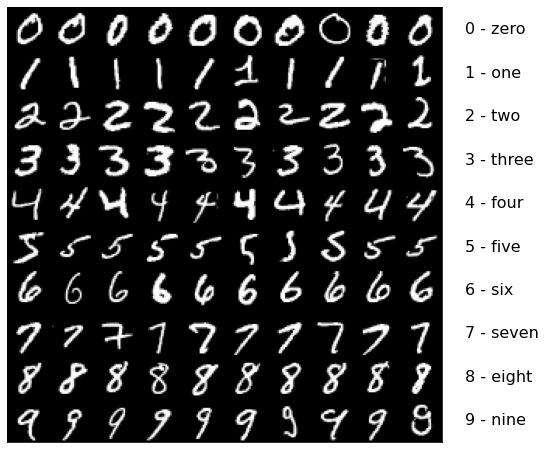

In [7]:
plot_dataset(dataset)

### Creating DataLoader

Since the MNIST dataset is an iteratable one, we can create pytorch DataLoader! 

In [8]:
import torch
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=20,
                                     shuffle=True,
                                     num_workers=1,
                                     pin_memory=True)


**Review**: the first argument is you dataset, and it can be anything but requires two attributes: [`__len__`](https://docs.python.org/3/reference/datamodel.html#object.__len__) and [`__getitem__`](https://docs.python.org/3/reference/datamodel.html#object.__getitem__). In case you wonder, these attributes allow you to call `len(dataset)` and access dataset elements  by `dataset[X]` where `X` is an index integer.

#### Details (ignore if wished): other constructor arguments
The other constructor arguments used above are:
* `batch_size` ... the same of the subset data to be provided at once
* `shuffle` ... whether or not to randomize the choice of subset dataset (False will provide dataset
* `num_workers` ... number of parallel data-reader processes to be run (for making data read faster using `multiprocessing` module)
* `pin_memory` ... speed up data transfer to GPU by avoiding a necessity to copy data from pageable memory to page-locked (pinned) memory. Read [here](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/) for more details. If you are not sure about the details, set to `True` when using GPU. 

### Data streaming with `DataLoader`
So let's play with it! First of all, it has the concept of "length".

In [9]:
print('length of DataLoader:',len(loader))
print('By the way, batch size * length =', 20 * len(loader))

length of DataLoader: 3000
By the way, batch size * length = 60000


We know the data total statistics is 60,000 which coincides with the length of `DataLoader` instance and the batch size where the latter is the unit of batch data. **Yep, as you guessed**, `DataLoader` is iterable: 

In [10]:
# Create an iterator for playin in this notebook
from itertools import cycle
iter = cycle(loader)

for i in range(10):
    batch = next(iter)    
    print('Iteration',i)
    print(batch[1]) # accessing the labels

Iteration 0
tensor([8, 3, 5, 2, 9, 2, 3, 7, 2, 6, 8, 4, 1, 0, 4, 7, 6, 7, 3, 2])
Iteration 1
tensor([5, 0, 5, 2, 7, 2, 7, 7, 3, 7, 0, 9, 8, 9, 0, 7, 4, 7, 3, 3])
Iteration 2
tensor([0, 6, 1, 2, 3, 8, 2, 6, 3, 2, 5, 9, 2, 9, 5, 9, 2, 0, 5, 6])
Iteration 3
tensor([5, 2, 7, 7, 7, 3, 1, 1, 0, 1, 1, 7, 6, 5, 9, 3, 0, 5, 6, 2])
Iteration 4
tensor([5, 2, 4, 9, 6, 8, 4, 1, 5, 8, 1, 7, 5, 5, 9, 3, 1, 7, 8, 5])
Iteration 5
tensor([7, 1, 9, 3, 3, 2, 2, 4, 1, 5, 4, 6, 1, 8, 2, 5, 3, 8, 0, 2])
Iteration 6
tensor([1, 3, 3, 6, 2, 7, 5, 8, 7, 6, 4, 2, 0, 1, 3, 3, 1, 1, 7, 4])
Iteration 7
tensor([4, 9, 8, 4, 4, 7, 1, 1, 5, 3, 5, 1, 8, 0, 7, 2, 7, 5, 3, 3])
Iteration 8
tensor([3, 0, 8, 2, 2, 0, 2, 3, 0, 9, 0, 2, 6, 6, 1, 3, 0, 7, 4, 3])
Iteration 9
tensor([8, 1, 1, 7, 2, 4, 8, 2, 2, 7, 0, 2, 5, 3, 7, 1, 2, 9, 1, 5])


... and this is how `data` looks like:

In [11]:
print('Shape of an image batch data',batch[0].shape)

Shape of an image batch data torch.Size([20, 1, 28, 28])


... which is quite naturally 20 of 28x28 image

## CIFAR10 

`CIFAR10` is yet another public dataset of 32x32 pixels RGB photographs. It contains 10 classes like MNIST but it is much more complicated than a gray scale, hand-written digits.

Extracting ./cifar10-data/cifar-10-python.tar.gz to ./cifar10-data



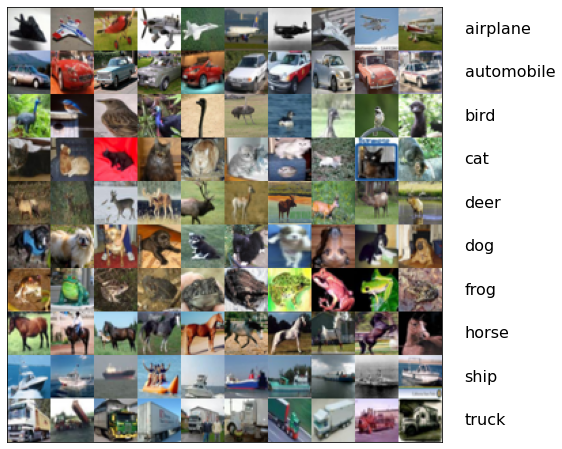

In [12]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './cifar10-data'
# Create the dataset
dataset = datasets.CIFAR10(LOCAL_DATA_DIR, train=True, download=True,
                           transform=transforms.Compose([transforms.ToTensor()]))

plot_dataset(dataset)

Nothing new in terms of how-to, but let's also create a `DataLoader` with `CIFAR10`.

In [13]:
loader = torch.utils.data.DataLoader(dataset,batch_size=8,shuffle=True,num_workers=1,pin_memory=True)

batch = next(cycle(loader))

Let's take a look at the `batch` data. Recall the shape of this image $(C,H,W)$ where `matplotlib.pyplot.imshow` takes the format $(H,W,C)$ just like how an ordinary photograph is presented. We use `torch.permute` function to swap the axis.

dog


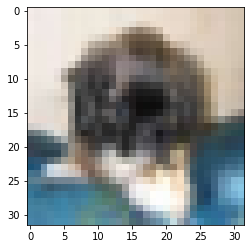

frog


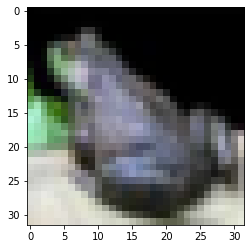

frog


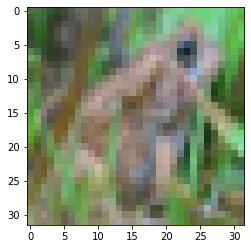

horse


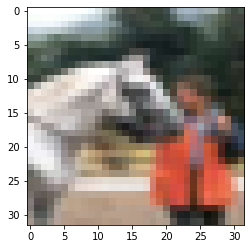

truck


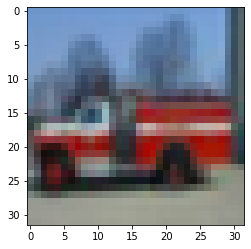

airplane


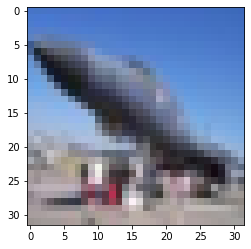

deer


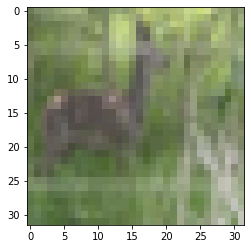

horse


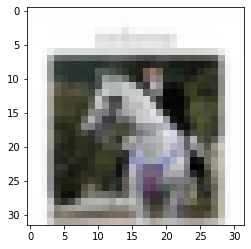

In [16]:
photos,labels=batch
for idx in range(len(photos)):
    photo = photos[idx].permute(1,2,0)
    label = labels[idx]
    print(dataset.classes[label])
    plt.imshow(photo)
    plt.show()

Any questions? As usual feel free to [hit Kazu](mailto:kterao@slac.stanford.edu).